In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')

## Base model

========== starting features ==========
* Neighborhood (ohe)
* Overall Qual
* Year Built
* Gr Liv Area
* Yr Sold

In [3]:
cols = ['Neighborhood', 'Overall Qual', 'Year Built', 'Gr Liv Area', 'SalePrice']

#### Normalize price

In [4]:
df['LogPrice_clipped'] = df['SalePrice'].transform(np.log).clip(lower = 10.5)

##### Replace small neighborhoods

In [5]:
df.groupby('Neighborhood').agg([np.mean, len])[['SalePrice']].sort_values(by = ('SalePrice', 'len')).head()

SalePrice    
                       mean len
Neighborhood                   
Landmrk       137000.000000   1
GrnHill       280000.000000   2
Greens        188666.666667   3
Blueste       144566.666667   6
Veenker       253570.588235  17

In [6]:
small_neighborhoods = df.groupby('Neighborhood').agg([np.mean, len])[['SalePrice']].sort_values(by = ('SalePrice', 'len')).index[:4]
small_neighborhoods


Index(['Landmrk', 'GrnHill', 'Greens', 'Blueste'], dtype='object', name='Neighborhood')

In [7]:
df['Neighborhood'] = df['Neighborhood'].transform(lambda x: 'other' if x in small_neighborhoods else x)

In [8]:
test_df['Neighborhood'] = test_df['Neighborhood'].transform(lambda x: 'other' if x in small_neighborhoods else x)

### Handle outliers

In [9]:
df_clean = df.query('`Gr Liv Area` < 4000').copy()

### Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [11]:
X = df_clean[cols[:-1]]
y = df_clean['LogPrice_clipped']

In [12]:
X_all = df[cols[:-1]]
y_all = df['LogPrice_clipped']

In [13]:
X.head()

,Neighborhood,Overall Qual,Year Built,Gr Liv Area
0,Sawyer,6,1976,1479
1,SawyerW,7,1996,2122
2,NAmes,5,1953,1057
3,Timber,5,2006,1444
4,SawyerW,6,1900,1445


#### Numeric only version

In [14]:
X_num = X.drop(columns='Neighborhood')
X_num_all = X_all.drop(columns = 'Neighborhood')

In [15]:
pipe_num = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

In [16]:
pipe_num.fit(X_num, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [17]:
pipe_num.score(X_num, y)

0.8156224724504684

In [18]:
pipe_num.score(X_num_all, y_all)

0.7947466405171462

In [19]:
pipe_num.named_steps['linearregression'].coef_, X_num.columns

(array([0.18339452, 0.10429819, 0.15941886]),
 Index(['Overall Qual', 'Year Built', 'Gr Liv Area'], dtype='object'))

#### Neighborhood one hot encoded version

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.base import clone

In [21]:
ohe = OneHotEncoder()

In [22]:
ct = make_column_transformer(
    (OneHotEncoder(sparse=False), ['Neighborhood']),
    remainder='passthrough'
)

In [23]:
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(sparse=False),
                                 ['Neighborhood'])])

In [24]:
# pd.DataFrame.sparse.from_spmatrix(ct.fit_transform(X)).head()

In [25]:
pipe = make_pipeline(ct, clone(pipe_num))

In [26]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Neighborhood'])])),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('linearregression', LinearRegression())]))])

In [27]:
X.head()

,Neighborhood,Overall Qual,Year Built,Gr Liv Area
0,Sawyer,6,1976,1479
1,SawyerW,7,1996,2122
2,NAmes,5,1953,1057
3,Timber,5,2006,1444
4,SawyerW,6,1900,1445


In [28]:
X.shape

(2049, 4)

In [29]:
pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Neighborhood'])])),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('linearregression', LinearRegression())]))])

In [30]:
pipe.score(X_all, y_all)

0.8344597495460165

### Features correlated with residuals

In [31]:
y_preds_num = pipe_num.predict(X_num)

In [32]:
num_residuals = y_preds_num - y

In [33]:
df_clean['base_num_resid'] = num_residuals

<AxesSubplot:>

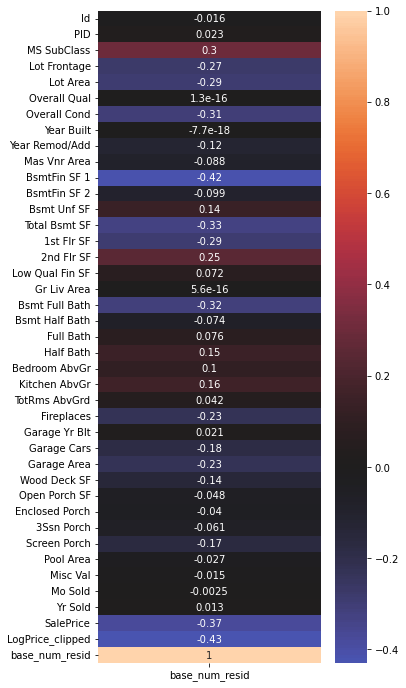

In [34]:
plt.figure(figsize = (5, 12))
sns.heatmap(df_clean.corr()[['base_num_resid']], center = 0, annot = True)

* negative correlation of SalePrice indicates potential non linear relationship
* Garage importance has diminished.
* Overall cond correlation changed from -0.1 to -0.3

In [48]:
y_preds = pipe.predict(X_all)
residuals = y_preds - y_all
df['residuals'] = residuals

In [45]:
df_clean.shape

(2049, 84)

In [46]:
df.shape

(2051, 82)

In [47]:
residuals.shape

(2051,)

<AxesSubplot:>

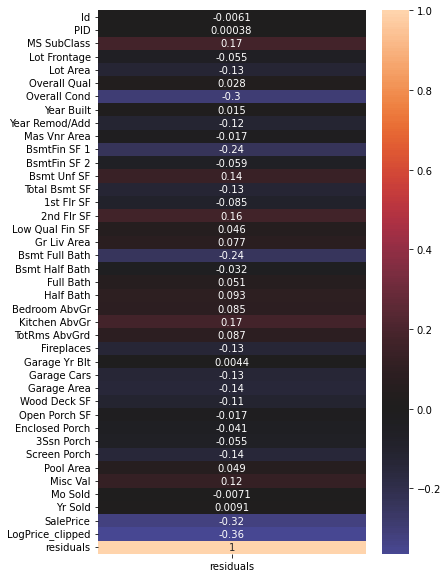

In [49]:
plt.figure(figsize = (6, 10))
sns.heatmap(df.corr()[['residuals']], center = 0, annot = True)

### Save predictions

In [37]:
X_test_num = test_df[['Overall Qual', 'Year Built', 'Gr Liv Area']]
X_test = test_df[['Neighborhood', 'Overall Qual', 'Year Built', 'Gr Liv Area']]

In [38]:
X_test.head()

,Neighborhood,Overall Qual,Year Built,Gr Liv Area
0,OldTown,6,1910,1928
1,Sawyer,5,1977,1967
2,Gilbert,7,2006,1496
3,OldTown,5,1923,968
4,NAmes,6,1963,1394


In [39]:
X.head()

,Neighborhood,Overall Qual,Year Built,Gr Liv Area
0,Sawyer,6,1976,1479
1,SawyerW,7,1996,2122
2,NAmes,5,1953,1057
3,Timber,5,2006,1444
4,SawyerW,6,1900,1445


In [40]:
test_df['num_preds'] = pipe_num.predict(X_test_num)
test_df['preds'] = pipe.predict(X_test)

In [41]:
test_df['preds']

0      11.885034
1      12.096681
2      12.189843
3      11.510369
4      11.991143
         ...    
873    12.148454
874    12.184381
875    11.834786
876    11.617036
877    11.703953
Name: preds, Length: 878, dtype: float64

In [42]:
test_df['SalePrice'] = np.exp(test_df['num_preds'])
test_df[['Id', 'SalePrice']].to_csv('base_model_num.csv', index=False)

In [43]:
test_df['SalePrice']

0      153299.622315
1      172059.763067
2      210935.447677
3      102843.156502
4      154526.919479
           ...      
873    188095.012636
874    189752.599956
875    130134.239629
876    103132.704227
877    113265.789304
Name: SalePrice, Length: 878, dtype: float64

In [44]:
test_df['SalePrice'] = np.exp(test_df['preds'])
test_df[['Id', 'SalePrice']].to_csv('base_model.csv', index=False)

##### Save residuals.

In [52]:
residuals.to_csv('datasets/base_residuals.csv')